In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
import joblib

# DATA AND FUNCTIONS

In [2]:
# Load the dataset
data = pd.read_csv(r"revisedLoL_matchdata.csv")

# Drop an 'index' column that is there by my data collection mistake
data = data.drop(['index'],axis=1)

# Default red team Id = 200. Change the red team ID to 0 and blue to 1. 
data['winning_team'] = data['winning_team'].replace([200,100],[0,1])
data.head(5)

,game_id,winning_team,in_game_time,ally_top_level,ally_jgl_level,ally_mid_level,ally_bot_level,ally_sup_level,enemy_top_level,enemy_jgl_level,...,dragon_killed,dragon_lost,voidgrub_killed,voidgrub_lost,riftherald_killed,riftherald_lost,baron_killed,baron_lost,champion_killed,champion_death
0,7358388756,0.0,10.003517,7.0,7.0,7.0,8.0,5.0,8.0,6.0,...,0,1,0,1,0,0,0,0,1,2
1,7358388756,0.0,13.004633,9.0,8.0,8.0,9.0,7.0,9.0,9.0,...,0,1,0,3,0,1,0,0,1,7
2,7358388756,0.0,15.277683,10.0,9.0,9.0,10.0,7.0,11.0,10.0,...,0,1,0,6,0,1,0,0,5,17
3,7347700848,0.0,10.003133,8.0,7.0,9.0,7.0,5.0,7.0,7.0,...,0,0,0,3,0,0,0,0,2,2
4,7347700848,0.0,13.004267,11.0,8.0,10.0,8.0,6.0,8.0,8.0,...,0,1,0,3,1,0,0,0,3,4


In [3]:
# Feature and Response
X = data.drop(['game_id','winning_team'],axis=1)
Y = data['winning_team']

In [4]:
# K-Fold object
k_folds = KFold(n_splits=5, shuffle = True, random_state = 123)

In [5]:
# Define a function to compute the ECE
def ECE_score(y, class1_proba, num_bins=10):
    # class1_proba: an array of probability belonging to class 1 
    # y: an array of observed outcome

    prob_true,prob_pred = calibration_curve(y, class1_proba, n_bins = num_bins)
    ECE = 0
    
    num_bins = len(prob_true)
    
    for bin in range(num_bins):
        # count how many samples are in current bin
        bin_count = len(class1_proba[(class1_proba >= bin/num_bins) & (class1_proba < (bin+1)/num_bins)])
        
        # add the weighted absolute difference between true and estimated probability of each bin
        ECE += bin_count * abs(prob_true[bin] - prob_pred[bin])
        
    # return the normalize ECE by sample size
    return ECE/len(class1_proba)

# TRAINING

In [6]:
# Split the training data into train/validation/test set. The split is 60/20/20
# Validation set used to calibrate the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 123)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size = 0.25, shuffle = True, random_state = 789)

In [7]:
# scaler object
scaler = StandardScaler().fit(x_train)

In [188]:
## Train the model. Params C was found using 5-fold CV.
#LR = LogisticRegression(C = 0.0159, max_iter = 1000).fit(scaler.transform(x_train),y_train)
#RF = RandomForestClassifier(oob_score = True, n_jobs = -1).fit(x_train,y_train)
#SVM = LinearSVC(C = 0.00216, max_iter = 1000, dual = False).fit(scaler.transform(x_train),y_train)

## Saving the trained model. Uncomment to use when needed 
#joblib.dump(LR,'LR.pkl')
#joblib.dump(RF,'RF.pkl')
#joblib.dump(SVM, 'SVM.pkl')

## Loading the trained model. Uncomment to use when needed
LR = joblib.load('LR.pkl')
RF = joblib.load('RF.pkl')
SVM = joblib.load('SVM.pkl')

# Train a dummy model.
Dummy = DummyClassifier(strategy ='most_frequent').fit(x_train,y_train)

# Calibration

In [189]:
## Calibrate previously trained models using Platt scaling.
#LR_cal = CalibratedClassifierCV(LR, cv = 'prefit', n_jobs = -1).fit(scaler.transform(x_val),y_val)
#RF_cal = CalibratedClassifierCV(RF, cv = 'prefit', n_jobs = -1).fit(x_val,y_val)
#SVM_cal = CalibratedClassifierCV(SVM, cv ='prefit', n_jobs = -1).fit(scaler.transform(x_val),y_val)

## Saving the trained model. Uncomment to use when needed 
#joblib.dump(LR_cal,'LR_cal.pkl')
#joblib.dump(RF_cal,'RF_cal.pkl')
#joblib.dump(SVM_cal, 'SVM_cal.pkl')


## Loading the calibration models. Uncomment to use when needed
LR_cal = joblib.load('LR_cal.pkl')
RF_cal = joblib.load('RF_cal.pkl')
SVM_cal  = joblib.load('SVM_cal.pkl')

# Metric

### ACCURACY AND ECE

In [190]:
# Model predictions on test set
LR_pred = LR.predict(scaler.transform(x_test))
RF_pred = RF.predict(x_test)
SVM_pred = SVM.predict(scaler.transform(x_test))

LR_cal_pred = LR_cal.predict(scaler.transform(x_test))
RF_cal_pred = RF_cal.predict(x_test)
SVM_cal_pred = SVM_cal.predict(scaler.transform(x_test))

# Model prediction probability on test set. 
# Only care about the probability of belong in class 1
LR_proba = LR.predict_proba(scaler.transform(x_test))[:,1]
RF_proba = RF.predict_proba(x_test)[:,1]
# SVM model does not have a probability estimate

# Calibration method can assign a probability to SVM models.
LR_cal_proba = LR_cal.predict_proba(scaler.transform(x_test))[:,1]
RF_cal_proba = RF_cal.predict_proba(x_test)[:,1]
SVM_cal_proba = SVM_cal.predict_proba(scaler.transform(x_test))[:,1]

In [191]:
# Accuracy on train set
trainDummy_acc = accuracy_score(y_train,Dummy.predict(x_train))
trainLR_acc = accuracy_score(y_train, LR.predict(scaler.transform(x_train)))
trainRF_acc = accuracy_score(y_train, RF.predict(x_train))
trainSVM_acc = accuracy_score(y_train, SVM.predict(scaler.transform(x_train)))

# ECE on train set
trainLR_ece = ECE_score(y_train, LR.predict_proba(scaler.transform(x_train))[:,1])
trainRF_ece = ECE_score(y_train, RF.predict_proba(x_train)[:,1])

# Compute train score for calibrated models. Doesn't work with cross_val_score for some reason:
#for 

trainLR_cal_acc = accuracy_score(y_train, LR_cal.predict(scaler.transform(x_train)))
trainRF_cal_acc = accuracy_score(y_train, RF_cal.predict(x_train))
trainSVM_cal_acc = accuracy_score(y_train, SVM_cal.predict(scaler.transform(x_train)))

# ECE on train set
trainLR_cal_ece = ECE_score(y_train, LR_cal.predict_proba(scaler.transform(x_train))[:,1])
trainRF_cal_ece = ECE_score(y_train, RF_cal.predict_proba(x_train)[:,1])
trainSVM_cal_ece = ECE_score(y_train, SVM_cal.predict_proba(scaler.transform(x_train))[:,1])



In [192]:
# Accuracy on test set
testDummy_acc = accuracy_score(y_test,Dummy.predict(x_test))
testLR_acc = accuracy_score(y_test, LR_pred)
testRF_acc = accuracy_score(y_test, RF_pred)
testSVM_acc = accuracy_score(y_test, SVM_pred)

testLR_cal_acc = accuracy_score(y_test, LR_cal_pred)
testRF_cal_acc = accuracy_score(y_test, RF_cal_pred)
testSVM_cal_acc = accuracy_score(y_test, SVM_cal_pred)

# ECE on test set
testLR_ece = ECE_score(y_test, LR_proba)
testRF_ece = ECE_score(y_test, RF_proba)

testLR_cal_ece = ECE_score(y_test,LR_cal_proba)
testRF_cal_ece = ECE_score(y_test, RF_cal_proba)
testSVM_cal_ece = ECE_score(y_test, SVM_cal_proba)

In [193]:
results_table = pd.DataFrame({'Train Accuracy': np.round([trainLR_acc, trainRF_acc, trainSVM_acc], 3),
                              'Test Accuracy': np.round([testLR_acc, testRF_acc, testSVM_acc], 3), 
                              'Calibrated Train Accuracy': np.round([trainLR_cal_acc, trainRF_cal_acc, trainSVM_cal_acc], 3),
                              'Calibrated Test Accuracy': np.round([testLR_cal_acc, testRF_cal_acc, testSVM_cal_acc], 3),
                              'Train ECE': np.round([trainLR_ece, trainRF_ece, 0], 4),
                              'Test ECE': np.round([testLR_ece, testRF_ece, 0],4),
                              'Calibrated Train ECE': np.round([trainLR_cal_ece, trainRF_cal_ece, trainSVM_cal_ece], 4),
                              'Calibrated Test ECE': np.round([testLR_cal_ece, testRF_cal_ece, testSVM_cal_ece], 4)},
                             index = ['LR', 'RF', 'SVM'])

# Change the 0 for SVM ECE to None
results_table['Train ECE'][2] = None
results_table['Test ECE'][2] = None

# Column for the dummy model
results_table.loc['Dummy'] = [np.round(trainDummy_acc,3), np.round(testDummy_acc,3), None, None, None, None, None, None]

In [194]:
results_table

,Train Accuracy,Test Accuracy,Calibrated Train Accuracy,Calibrated Test Accuracy,Train ECE,Test ECE,Calibrated Train ECE,Calibrated Test ECE
LR,0.850,0.851,0.85,0.851,0.0149,0.0144,0.0149,0.0147
RF,1.000,0.856,1.00,0.853,0.0982,0.0873,0.0344,0.0175
SVM,0.850,0.850,0.85,0.850,NaN,NaN,0.0129,0.0138
Dummy,0.527,0.524,NaN,NaN,NaN,NaN,NaN,NaN


### DIAGRAMS

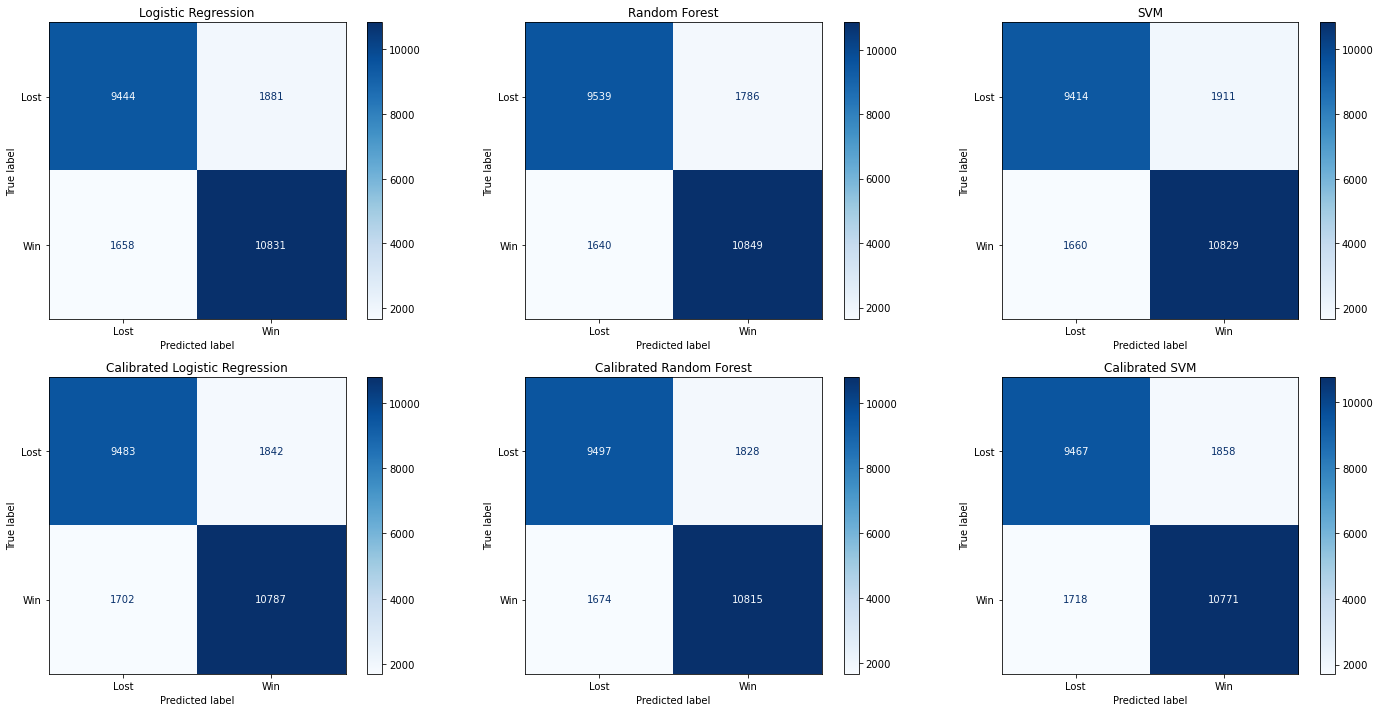

In [195]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (20,10))

models = [LR, RF, SVM, LR_cal, RF_cal, SVM_cal]
models_name = ['Logistic Regression', 'Random Forest', 'SVM', 
               'Calibrated Logistic Regression', 'Calibrated Random Forest', 'Calibrated SVM']
for model, name, ax in zip(models, models_name, axes.flatten()):
    if model in [RF,RF_cal]:
        plot_confusion_matrix(model, x_test, y_test, ax=ax, display_labels=['Lost', 'Win'], cmap='Blues')
    else:
        plot_confusion_matrix(model, scaler.transform(x_test), y_test, ax=ax, display_labels=['Lost', 'Win'],cmap='Blues')
    ax.title.set_text(name)
    
plt.tight_layout()  
plt.show()

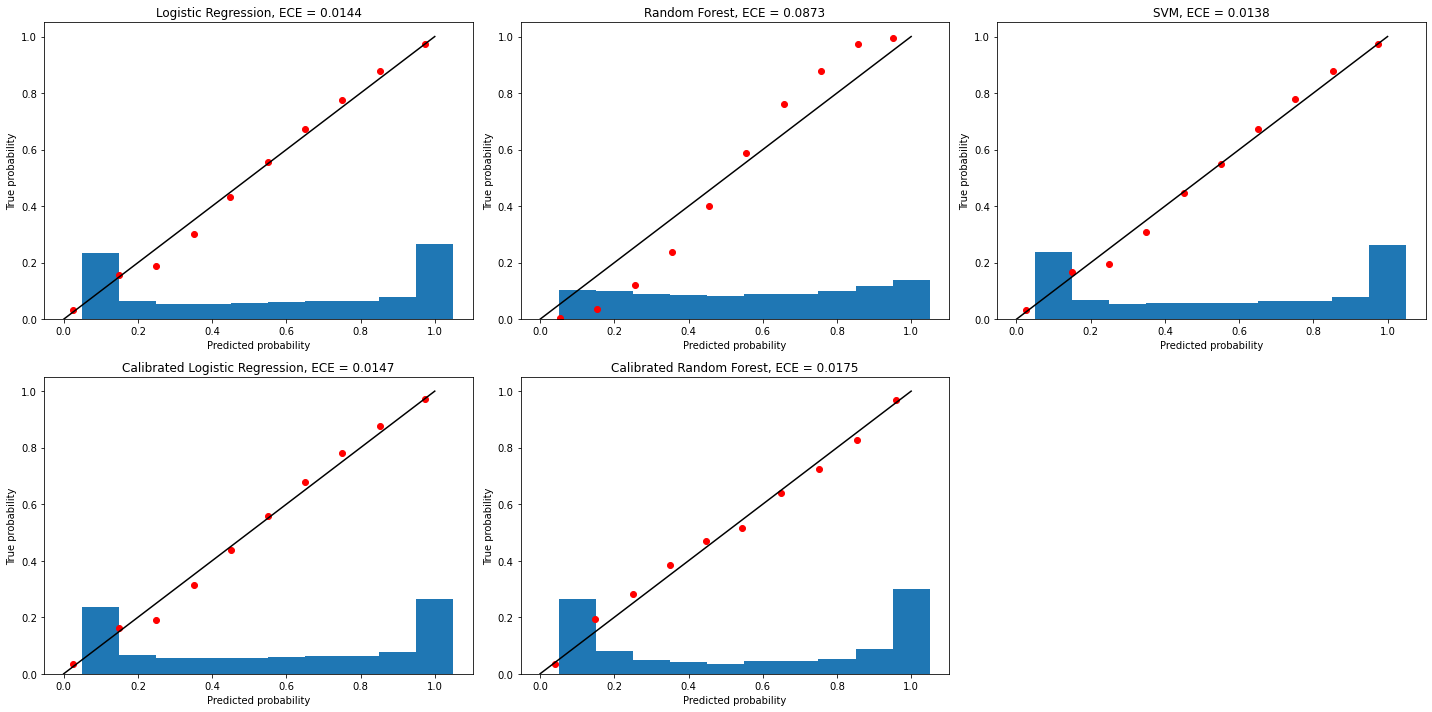

In [283]:
# Perfect calibration line
x = np.linspace(0,1)
y = x

fig2, axes2 = plt.subplots(nrows=2, ncols=3, figsize = (20,10))

models_proba = [LR_proba, RF_proba, SVM_cal_proba, LR_cal_proba, RF_cal_proba, ]
models_ece = [testLR_ece, testRF_ece, testSVM_cal_ece, testLR_cal_ece, testRF_cal_ece,]

for proba, ece, name, ax in zip(models_proba, models_ece, models_name, axes2.flatten()):
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins = 10)
    num_bins = len(prob_true)
    bin_count = [len(proba[(proba >= bin/num_bins) & 
                           (proba < (bin+1)/num_bins)]) for bin in range(num_bins)]
    ax.bar(np.arange(0.1,1.1,0.1),np.array(bin_count)/len(proba), width = 0.1, zorder=-1)
    ax.plot(x,y,color='black')
    ax.scatter(prob_pred,prob_true,color='r')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability')
    ax.title.set_text(f'{name}, ECE = {ece:.4f}')

fig2.delaxes(axes2[1,2])
plt.tight_layout()
plt.show()

# METRIC AS FUNCTION OF IN-GAME TIME

In [218]:
# Game stages dict
# Key is a time interval in the game, e.g [10,13). Up to [37,40) and everything else is 40+
game_stages_X = {f'[{i},{i+3})': x_test[(x_test['in_game_time'] >= i) & (x_test['in_game_time'] < i+3)] for i in range(10,40,3)}
game_stages_X['40+'] = x_test[x_test['in_game_time'] >= 40]

In [219]:
LR_acc_over_time = [accuracy_score(y_test[game_stages_X[time_interval].index], 
                                   LR.predict(scaler.transform(game_stages_X[time_interval])))
                    for time_interval in game_stages_X]
RF_acc_over_time = [accuracy_score(y_test[game_stages_X[time_interval].index], 
                                   RF.predict(game_stages_X[time_interval]))
                    for time_interval in game_stages_X]
SVM_acc_over_time = [accuracy_score(y_test[game_stages_X[time_interval].index], 
                                   SVM.predict(scaler.transform(game_stages_X[time_interval])))
                    for time_interval in game_stages_X]
Dummy_acc_over_time = [accuracy_score(y_test[game_stages_X[time_interval].index], 
                                   Dummy.predict(game_stages_X[time_interval]))
                    for time_interval in game_stages_X]

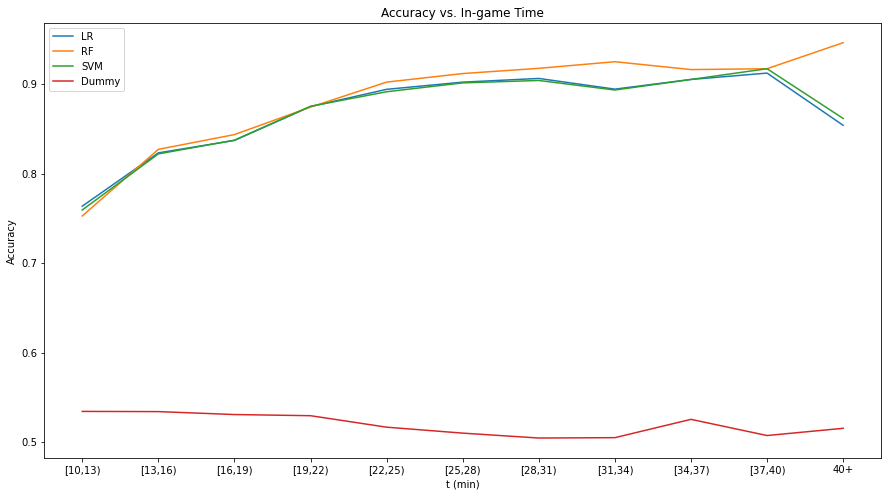

In [248]:
time_intervals = game_stages_X.keys()

fig = plt.figure()
fig.set_size_inches(15,8)

plt.plot(time_intervals, LR_acc_over_time, label = 'LR')
plt.plot(time_intervals, RF_acc_over_time, label = 'RF')
plt.plot(time_intervals, SVM_acc_over_time, label = 'SVM')
plt.plot(time_intervals, Dummy_acc_over_time, label = 'Dummy')
plt.xlabel('t (min)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. In-game Time')
plt.legend()
plt.savefig('Accuracy_vs_Time.png')
plt.show()


In [221]:
LR_ece_over_time = [ECE_score(y_test[game_stages_X[time_interval].index], 
                                   LR.predict_proba(scaler.transform(game_stages_X[time_interval]))[:,1])
                    for time_interval in game_stages_X]
RF_ece_over_time = [ECE_score(y_test[game_stages_X[time_interval].index], 
                                   RF.predict_proba(game_stages_X[time_interval])[:,1])
                    for time_interval in game_stages_X]
SVM_ece_over_time = [ECE_score(y_test[game_stages_X[time_interval].index], 
                                   SVM_cal.predict_proba(scaler.transform(game_stages_X[time_interval]))[:,1])
                    for time_interval in game_stages_X]

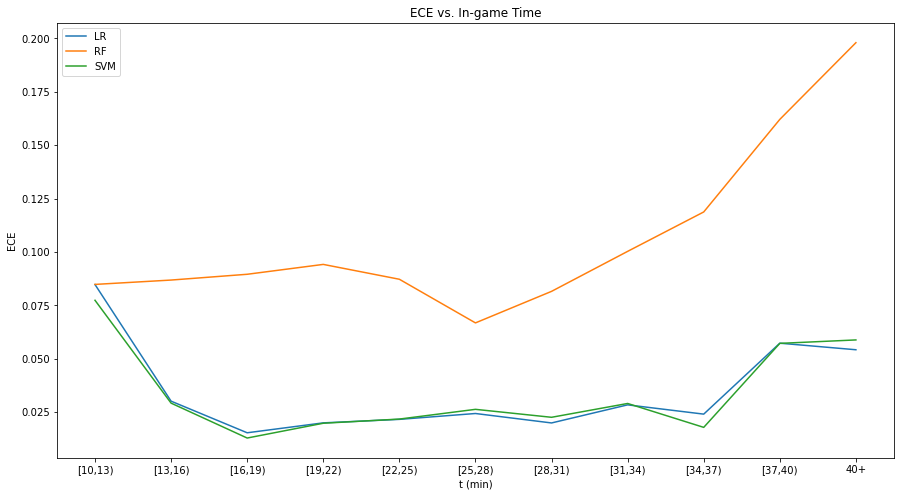

In [222]:
fig = plt.figure()
fig.set_size_inches(15,8)

plt.plot(time_intervals, LR_ece_over_time, label = 'LR')
plt.plot(time_intervals, RF_ece_over_time, label = 'RF')
plt.plot(time_intervals, SVM_ece_over_time, label = 'SVM')
plt.xlabel('t (min)')
plt.ylabel('ECE')
plt.title('ECE vs. In-game Time')
plt.legend()
#plt.savefig('Accuracy_vs_Time.png')
plt.show()

### TRAIN/TEST IN-GAME TIME DISTRIBUTION

In [233]:
train_bin = [len(x_train[(x_train['in_game_time'] >= i) & 
                 (x_train['in_game_time'] < i+3)]) for i in range(10,40,3)] + \
            [len(x_train[x_train['in_game_time'] > 40])]


In [237]:
hist = np.array(train_bin)/len(x_train)

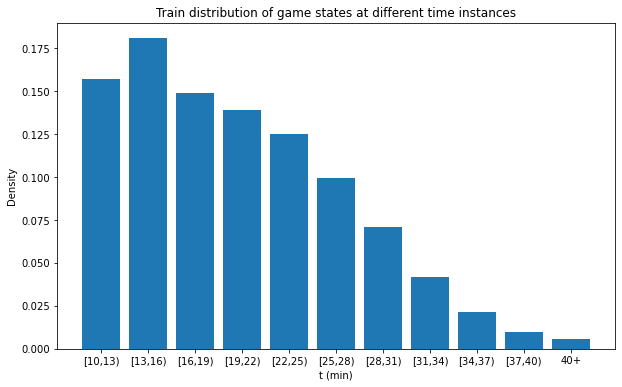

In [246]:
plt.figure(figsize = (10,6))
plt.bar(time_intervals, hist)
plt.xlabel('t (min)')
plt.ylabel('Density')
plt.title('Train distribution of game states at different time instances')
plt.show()

# CASE STUDY: EFFECT OF BARON

In [202]:
# Game states where a baron is killed. If lost, indicate the baron is killed by enemy team. 
baron_killed = X[X['baron_killed'].diff() == 1]
baron_lost = X[X['baron_lost'].diff() == 1]

# Game states right before a baron is killed. 
before_baron_killed = X.loc[np.array(baron_killed.index)-1]
before_baron_lost = X.loc[np.array(baron_lost.index)-1]

In [250]:
# The estimated win probability before baron capture
win_proba_before_killed = np.array([LR_cal.predict_proba(before_baron_killed)[:,1],
                                    RF_cal.predict_proba(before_baron_killed)[:,1],
                                    SVM_cal.predict_proba(before_baron_killed)[:,1]])

win_proba_before_lost = np.array([LR_cal.predict_proba(before_baron_lost)[:,1],
                                  RF_cal.predict_proba(before_baron_lost)[:,1],
                                  SVM_cal.predict_proba(before_baron_lost)[:,1]])

# The estimated win probability after a baron capture
win_proba_killed  = np.array([LR_cal.predict_proba(baron_killed)[:,1],
                              RF_cal.predict_proba(baron_killed)[:,1],
                              SVM_cal.predict_proba(baron_killed)[:,1]])

win_proba_lost  = np.array([LR_cal.predict_proba(baron_lost)[:,1],
                            RF_cal.predict_proba(baron_lost)[:,1],
                            SVM_cal.predict_proba(baron_lost)[:,1]])

In [251]:
kill_proba_change = win_proba_killed - win_proba_before_killed 
lost_proba_change = win_proba_lost - win_proba_before_lost

In [265]:
print(np.mean(win_proba_before_killed,axis=1))
print(np.mean(win_proba_killed,axis=1))
print(np.mean(kill_proba_change,axis=1))

[0.36785599 0.75642636 0.36059204]
[0.43275245 0.80507891 0.42398342]
[0.06489646 0.04865255 0.06339138]


In [266]:
print(np.mean(win_proba_before_lost,axis=1))
print(np.mean(win_proba_lost,axis=1))
print(np.mean(lost_proba_change,axis=1))

[0.10303264 0.25202248 0.10052982]
[0.08879182 0.1942708  0.08587773]
[-0.01424082 -0.05775168 -0.01465208]


In [261]:
baron_effect = pd.DataFrame({'win probability before': np.round([np.mean(win_proba_before_killed), np.mean(win_proba_before_lost)],3),
                            'win probability after': np.round([np.mean(win_proba_killed), np.mean(win_proba_lost)],3),
                            'win probability change': np.round([np.mean(kill_proba_change), np.mean(lost_proba_change)],3)},
                            index = ['secured', 'lost'])

ValueError: Data must be 1-dimensional

In [253]:
baron_effect

,win probability before,win probability after,win probability change
secured,0.495,0.554,0.059
lost,0.152,0.123,-0.029


In [207]:
# Game states where a baron is killed in the time interval [20,30)
baron_killed_20to30 = baron_killed[(baron_killed['in_game_time'] >= 20) & (baron_killed['in_game_time'] < 30)]
baron_lost_20to30 = baron_lost[(baron_lost['in_game_time'] >= 20) & (baron_lost['in_game_time'] < 30)]

# Game states where a baron is killed in time interval [30,40)
baron_killed_30to40 = baron_killed[(baron_killed['in_game_time'] >= 30) & (baron_killed['in_game_time'] < 40)]
baron_lost_30to40 = baron_lost[(baron_lost['in_game_time'] >= 30) & (baron_lost['in_game_time'] < 40)]

# Game states where a baron is killed in time interval 40+
baron_killed_post40 = baron_killed[baron_killed['in_game_time'] >= 40]
baron_lost_post40 = baron_lost[baron_lost['in_game_time'] >= 40]

# Game states right before a baron is killed in time interval [20,30)
before_baron_killed_20to30 = X.loc[np.array(baron_killed_20to30.index)-1]
before_baron_lost_20to30 = X.loc[np.array(baron_lost_20to30.index)-1]

# Game states right before a baron is killed in time interval [30,40)
before_baron_killed_30to40 = X.loc[np.array(baron_killed_30to40.index)-1]
before_baron_lost_30to40 = X.loc[np.array(baron_lost_30to40.index)-1]

# Game states right before a baron is killed in time interval 40+
before_baron_killed_post40 = X.loc[np.array(baron_killed_post40.index)-1]
before_baron_lost_post40 = X.loc[np.array(baron_lost_post40.index)-1]

In [208]:
# The estimated win probability before baron capture in the time interval [20,30)
win_proba_before_killed_20to30 = RF_cal.predict_proba(before_baron_killed_20to30)[:,1]
win_proba_before_lost_20to30 = RF_cal.predict_proba(before_baron_lost_20to30)[:,1]

# The estimated win probability before baron capture in the time interval [30,40)
win_proba_before_killed_30to40 = RF_cal.predict_proba(before_baron_killed_30to40)[:,1]
win_proba_before_lost_30to40 = RF_cal.predict_proba(before_baron_lost_30to40)[:,1]

# The estimated win probability before baron capture in the time interval 40+
win_proba_before_killed_post40 = RF_cal.predict_proba(before_baron_killed_post40)[:,1]
win_proba_before_lost_post40 = RF_cal.predict_proba(before_baron_lost_post40)[:,1]

# The estimated win probability after a baron capture in time interval [20,30)
win_proba_killed_20to30  = RF_cal.predict_proba(baron_killed_20to30)[:,1]
win_proba_lost_20to30  = RF_cal.predict_proba(baron_lost_20to30)[:,1]

# The estimated win probability after a baron capture in time interval [30,40)
win_proba_killed_30to40  = RF_cal.predict_proba(baron_killed_30to40)[:,1]
win_proba_lost_30to40  = RF_cal.predict_proba(baron_lost_30to40)[:,1]

# The estimated win probability after a baron capture in time interval 40+
win_proba_killed_post40  = RF_cal.predict_proba(baron_killed_post40)[:,1]
win_proba_lost_post40  = RF_cal.predict_proba(baron_lost_post40)[:,1]

In [209]:
baron_effect_stages = pd.DataFrame({'before20to30': np.round([np.mean(win_proba_before_killed_20to30), np.mean(win_proba_before_lost_20to30)],3),
                                    'after20to30': np.round([np.mean(win_proba_killed_20to30), np.mean(win_proba_lost_20to30)],3),
                                    'before30to40': np.round([np.mean(win_proba_before_killed_30to40), np.mean(win_proba_before_lost_30to40)],3),
                                    'after30to40': np.round([np.mean(win_proba_killed_30to40), np.mean(win_proba_lost_30to40)],3),
                                    'beforepost40': np.round([np.mean(win_proba_before_killed_post40), np.mean(win_proba_before_lost_post40)],3),
                                    'afterpost40': np.round([np.mean(win_proba_killed_post40), np.mean(win_proba_lost_post40)],3)},
                                   index = ['secured', 'lost'])

In [210]:
baron_effect_stages.insert(loc = 2, column = 'change20to30', 
                           value = baron_effect_stages['after20to30'] - baron_effect_stages['before20to30'])
baron_effect_stages.insert(loc = 5, column = 'change30to40', 
                           value = baron_effect_stages['after30to40'] - baron_effect_stages['before30to40'])
baron_effect_stages['changepost40'] = baron_effect_stages['afterpost40'] - baron_effect_stages['beforepost40']

In [211]:
baron_effect_stages

,before20to30,after20to30,change20to30,before30to40,after30to40,change30to40,beforepost40,afterpost40,changepost40
secured,0.755,0.805,0.050,0.660,0.711,0.051,0.611,0.619,0.008
lost,0.253,0.194,-0.059,0.325,0.281,-0.044,0.399,0.352,-0.047


In [272]:
np.arange(0,1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])